In [1]:
import os
from groq import Groq
import re
import numpy as np
import yaml
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
params_path = os.path.join(os.getcwd(), 'config.yaml')
config = None
with open(params_path) as f:
    config = yaml.safe_load(f)

In [3]:
client = Groq(
    api_key = config['api']['groq']
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            'role': 'user',
            'content': 'Who is the greatest scientist of all time? Only give the name.',
        }
    ],
    model = 'llama-3.1-8b-instant',
    max_completion_tokens=1024,
)

print(chat_completion.choices[0].message.content)

Isaac Newton.


In [4]:
print(chat_completion.choices[0].message.content)

Isaac Newton.


In [5]:
responces = []

# Create new groq client
client = Groq(
        api_key = config['api']['groq']
    )

for _ in range(30):
    # Generate chat
    chat_completion = client.chat.completions.create(
        messages=[
            {
                'role': 'user',
                'content': 'Who is the greatest scientist of all time?',
            }
        ],
        model = 'llama-3.1-8b-instant',
        max_completion_tokens=1024,
    )

    # Add response to list 
    responces.append(chat_completion.choices[0].message.content)

print(responces)

['Determining the "greatest scientist of all time" is subjective and can depend on various factors such as the field of study, contributions, impact, and personal opinions. However, several scientists are often considered among the most influential and groundbreaking in history.\n\nSome notable contenders for the title of "greatest scientist of all time" include:\n\n1. **Isaac Newton** (1642-1727): An English mathematician and physicist who laid the foundation for classical mechanics with his laws of motion and universal gravitation.\n2. **Albert Einstein** (1879-1955): A Swiss-German physicist who revolutionized our understanding of space, time, and gravity with his theory of relativity.\n3. **Marie Curie** (1867-1934): A Polish-born physicist and chemist who pioneered radioactivity research and was the first woman to win a Nobel Prize.\n4. **Charles Darwin** (1809-1882): An English naturalist who proposed the theory of evolution through natural selection, fundamentally changing the f

In [6]:
with open("my_sentences.txt", "a") as file:
    for sentence in responces:
        file.write('\n'+'--'*50)
        file.write(sentence)

In [7]:
len(responces)

30

In [14]:
class UncertaintyQuantifier:
    def __init__(self):
        self.word_sets = []
        self.similarity_matrix = None
        self.eigenvalues = None
    
    def get_similarity_matrix(self):
        return self.similarity_matrix
    
    def get_eigenvalues(self):
        return self.eigenvalues

    def preprocess_sentence(self, sentence):
        words = re.findall(r'\b\w+\b', sentence.lower())
        return set(words)
    
    def jaccard_similarity(self, response1, response2):
        intersection = len(response1.intersection(response2))
        union = len(response1.union(response2))
        
        # Handle empty sets
        if union == 0:
            return 0.0
        
        return intersection / union
    
    def compute_similarity_matrix(self, responses):
        n = len(responses)
        self.similarity_matrix = np.zeros((n, n))
        
        # Preprocess all responses
        self.word_sets = [self.preprocess_sentence(sentence) for sentence in responses]
        print(self.word_sets)
        
        # Calculate pairwise similarities
        for i in range(n):
            for j in range(i, n):
                if i == j:
                    self.similarity_matrix[i, j] = 1.0  # Self-similarity is 1
                else:
                    sim = self.jaccard_similarity(self.word_sets[i], self.word_sets[j])
                    self.similarity_matrix[i, j] = self.similarity_matrix[j, i] = sim
        
        return self.similarity_matrix
    
    def num_semantic_sets(self, threshold = 0.5):
        n = len(self.similarity_matrix)
        if n <= 1:
            return n
        
        groups = list(range(n))  # Initially each response is its own group
        
        for i in range(n):
            for j in range(i + 1, n):
                # precomputed similarity from matrix
                jaccard = self.similarity_matrix[i, j]
                nli_scores = {
                        'entailment': jaccard,
                        'contradiction': 1 - jaccard
                }
                
                # Check bidirectional entailment
                if (nli_scores['entailment'] > threshold and 
                    nli_scores['entailment'] > nli_scores['contradiction']):
                    
                    min_group = min(groups[i], groups[j])
                    max_group = max(groups[i], groups[j])
                    groups = [min_group if g == max_group else g for g in groups]
        
        return len(set(groups))
    
    def eigenvalue_uncertainty(self):
        n = self.similarity_matrix.shape[0]
        if n <= 1:
            return 0.0
        
        # Compute degree matrix
        degree_matrix = np.diag(self.similarity_matrix.sum(axis=1))
        
        # Avoid division by zero
        degree_sqrt_inv = np.zeros_like(degree_matrix)
        for i in range(n):
            if degree_matrix[i, i] > 1e-10:
                degree_sqrt_inv[i, i] = 1.0 / np.sqrt(degree_matrix[i, i])
        
        # Compute Laplacian
        laplacian = np.eye(n) - degree_sqrt_inv @ self.similarity_matrix @ degree_sqrt_inv
        
        # Compute eigenvalues
        self.eigenvalues = np.linalg.eigvals(laplacian)
        self.eigenvalues = np.real(self.eigenvalues)
        self.eigenvalues = np.sort(self.eigenvalues)
        
        # Sum of (1 - lambda_k) for lambda_k <= 1
        uncertainty = sum(max(0, 1 - lam) for lam in self.eigenvalues if lam <= 1)
        return uncertainty
    
    def degree_based_measures(self):
        n = self.similarity_matrix.shape[0]
        
        # Compute degree for each node
        degrees = self.similarity_matrix.sum(axis=1)
        
        # Normalize degrees
        max_degree = n - 1 if n > 1 else 1
        normalized_degrees = degrees / max_degree
        
        # Uncertainty: average distance from maximum connectivity
        uncertainty = np.mean(1 - normalized_degrees)
        
        # Confidence: individual degrees (higher degree = higher confidence)
        confidence_scores = normalized_degrees
        
        return uncertainty, confidence_scores
    
    def eccentricity_measures(self, k = 2):
        n = self.similarity_matrix.shape[0]
        if n <= 1:
            return 0.0, np.array([1.0] * n)
        # Compute degree matrix
        degree_matrix = np.diag(self.similarity_matrix.sum(axis=1))
        
        # Avoid division by zero
        degree_sqrt_inv = np.zeros_like(degree_matrix)
        for i in range(n):
            if degree_matrix[i, i] > 1e-10:
                degree_sqrt_inv[i, i] = 1.0 / np.sqrt(degree_matrix[i, i])
        
        # Compute normalized Laplacian
        laplacian = np.eye(n) - degree_sqrt_inv @ self.similarity_matrix @ degree_sqrt_inv
        
        # Get k smallest eigenvectors
        k = min(k, n-1) if n > 1 else 1
        eigenvals, eigenvecs = eigh(laplacian)
        
        # Use first k eigenvectors for embedding
        embedding = eigenvecs[:, :k]
        
        # Center the embeddings
        centroid = np.mean(embedding, axis=0)
        centered_embedding = embedding - centroid
        
        # Calculate distances from center
        distances = np.linalg.norm(centered_embedding, axis=1)
        
        # Uncertainty: average distance from center
        uncertainty = np.mean(distances)
        
        # Confidence: negative distance (closer to center = higher confidence)
        max_dist = np.max(distances) if np.max(distances) > 0 else 1
        confidence_scores = 1 - (distances / max_dist)
        
        return uncertainty, confidence_scores

In [15]:
uq = UncertaintyQuantifier()

similar_matrix = uq.compute_similarity_matrix(responses=responces)


[{'role', 'led', 'it', 'nobel', 'subjective', 'most', 'among', 'contributing', 'however', 'marie', 'evolution', 'galileo', 'his', 'groundbreaking', 'physicist', 'just', 'mathematician', 'laws', 'some', 'as', 'born', '1867', 'paved', 'in', 'scientists', 'significant', 'prize', 'impact', 'speed', 'numerous', 'influential', 'opinion', 'proposed', 'difficult', 'through', 'revolution', 'breakthroughs', 'physics', 'charles', 'gravity', 'astrophysics', 'astronomer', 'chemist', 'swiss', 'can', '5', 'engineering', 'newton', 'fundamentally', 'times', 'mc²', 'motion', '1642', 'was', 'changing', 'other', 'depends', 'greatest', '4', '1934', 'importance', 'scientist', 'laid', 's', 'english', 'curie', 'italian', 'one', 'several', '1809', 'natural', 'also', 'german', 'albert', 'often', 'be', 'could', 'while', 'scientific', '1727', 'on', 'equals', 'such', 'matter', 'with', 'universe', 'foundation', 'our', 'who', 'history', 'energy', 'darwin', 'way', 'how', 'contributions', 'fields', 'are', 'include', '

In [16]:
group = uq.num_semantic_sets()
print(group)

20


In [18]:
un_egiv = uq.eigenvalue_uncertainty()
print(un_egiv)

2.34431414918478


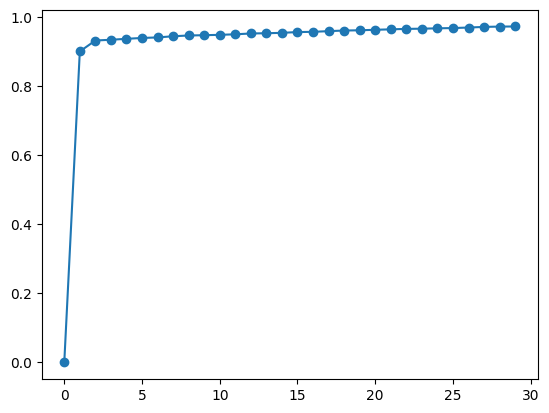

In [19]:
egin_val = uq.get_eigenvalues()
plt.plot(egin_val, marker='o')

In [20]:
deg_un, deg_conf = uq.degree_based_measures()
print(deg_un, deg_conf)

0.5576696444349646 [0.46213183 0.41903228 0.45226018 0.46317879 0.43505798 0.47212945
 0.45412614 0.4391464  0.45095706 0.44357805 0.47316268 0.42738818
 0.43117146 0.40433653 0.41599927 0.47557972 0.44944665 0.45973454
 0.41379419 0.42924612 0.46157788 0.4458564  0.44876232 0.40895051
 0.44373194 0.45523088 0.40701345 0.40789801 0.44268421 0.47674758]


In [25]:
ecc_un, ecc_conf = uq.eccentricity_measures(k=4)
print(ecc_un, ecc_conf)

0.2980815822605942 [0.50847834 0.54778629 0.52266791 0.31279466 0.6485407  0.4739231
 0.32953433 0.48713385 0.294762   0.68385122 0.69512935 0.32288596
 0.28922466 0.10603976 0.         0.56906785 0.38914657 0.7762616
 0.18621258 0.36361038 0.60650021 0.61385766 0.60441286 0.06895009
 0.59463248 0.62448335 0.5611042  0.16225969 0.30868567 0.52512641]
